# Task

Select a set $S = { S_1, S_2, …, S_n }$ of sequences of events from the set $E$:
* the size of set E has to be at least 10: $\#{E} \ge 10$,
* the average length of sequences > 5: $E[len(S_i)] > 5$,
* $n > 200$. 

For example: $S$ are the sentences from some book (project Gutenberg), events are letters in the sentences - $E$ is the alphabet extended with punctuation marks and space.

Construct a transition matrix of a Markov chain summarizing selected set S. Consider two options: you start counting with
* all entries set to 0
* all entries set to 1
Starting with 1 is beneficial because we won't have zero's.

Define a value $v(S)$ of a sequence $S = e_1,e_2,…,e_k$ as a geometric mean of probabilities of the corresponding transitions

$v(S) = ( p(e_1,e_2) \times p(e_2,e_3) \times p(e_3,e_4) \times … \times p(e_{k-1},e_k) )^{1/(k-1)}$

$v(S)$ is a multiplication of probabilities. A large value of v(S) means S is specific for that Markov chain.

Compute the distribution of values $v(S)$ for all sequences from $S$. Compare it with (a distribution of) values of some other sequences - for example another book in some other language.

# Data

I like the idea about books. So, I chose four books for the task:

1. Wuthering Heights by Emily Bronte [link](http://www.gutenberg.org/ebooks/768), the file name is **768.txt.zip**. It's in English with some rare and some words.
2. Odes and Epodes by Horace [link](http://www.gutenberg.org/ebooks/9646)

I was interested a bit into comparing an 'old' English with the relatively 'modern' English. For that reason, I also compared the distribution for the books

3. Romeo and Juliet by William Shakespeare [link](http://www.gutenberg.org/ebooks/2261)

All words in the book were converted to the lower case before processing.

# Global Settings

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
import logging

import re
import sys

import pandas as pd
import scipy
import sklearn
import statsmodels.api as sm

pd.set_option('display.max_rows',    100)
pd.set_option('display.max_columns', 100)

import matplotlib.pyplot as plt
plt.style.use('seaborn')

import nltk
nltk.download('punkt')

sequence_sets = {0: {'name':      'Wuthering Heights by Emily Bronte',
                     'file_name': 'data/768.txt.zip'}}

logger = logging.getLogger('main')

if (logger.hasHandlers()):
    logger.handlers.clear()

logger.addHandler(logging.StreamHandler(sys.stdout))
logger.handlers[-1].setFormatter(logging.Formatter(fmt='%(asctime)s - %(levelname)s - %(message)s', 
                                                   datefmt='%Y-%m-%d %H:%M:%S'))

logger.setLevel(logging.DEBUG)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dmitry\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Parsing Data

In [3]:
import zipfile

file_name = sequence_sets[0]['file_name']

with zipfile.ZipFile(file_name) as z:
    text = z.read(z.namelist()[0]).decode('utf-8')
    
logger.info('Read the textual information of the length %d' % len(text))

# let's take only those between the start_markek and end_marker
start_marker = '\*\*\*START OF THE PROJECT GUTENBERG EBOOK.+?\*\*\*'
end_marker   = '\*\*\*END OF THE PROJECT GUTENBERG EBOOK.+?\*\*\*'

m = re.search(start_marker + '(.+?)' + end_marker, text, re.DOTALL)

if m:
    text = m[1]
    
logger.info('The length after taking the part between the markers: %d' % len(text))    

2018-06-24 13:34:28 - INFO - Read the textual information of the length 681636
2018-06-24 13:34:28 - INFO - The length after taking the part between the markers: 661977


In [4]:
words = nltk.tokenize.word_tokenize(text, language='english')

# Building Transition Matrix

In [5]:
from collections import defaultdict

# transition matrix
tm = defaultdict(dict)

# bag of the words
bw = defaultdict(int)

for word in words:
    if word.isalpha() and len(word) > 1:
        # word in the lowercase
        word2 = word.lower()
        bw[word2] += 1
        for i in range(len(word2) - 1):
            try:
                c = tm[word2[i]][word2[i+1]]
            except KeyError:
                tm[word2[i]][word2[i+1]] = 0
            tm[word2[i]][word2[i+1]] += 1

In [6]:
tm2 = pd.DataFrame(tm).fillna(0).astype('int').transpose().sort_index()

# adding missing columns
for column_name in tm2.index.difference(tm2.columns):
    tm2[column_name] = 0
        
tm2 = tm2.sort_index(axis=1)

tm2

,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,t,u,v,w,x,y,z
a,2,764,1072,1757,8,362,622,88,1660,4,594,2124,820,8468,2,631,0,3690,3765,5641,426,1110,439,25,960,60
b,377,60,0,10,2463,0,0,4,225,63,0,821,1,0,658,0,0,458,168,55,760,10,1,0,465,0
c,1667,0,197,2,1909,0,0,1693,351,0,651,880,0,0,2378,0,30,469,5,779,352,0,0,0,66,0
d,454,0,1,194,2307,18,192,4,1402,4,5,352,34,55,1174,0,0,387,377,4,227,48,9,0,259,0
e,3884,43,1055,6533,1717,522,286,139,670,22,137,2196,1036,4570,62,939,91,9106,3096,1824,14,934,313,630,676,13
f,705,0,0,0,783,874,0,0,729,0,0,263,0,1,1645,0,0,804,9,415,414,0,0,0,13,0
g,752,1,0,2,1156,0,91,1433,404,0,0,302,11,118,645,1,0,659,172,45,271,0,0,0,16,0
h,5027,27,484,5,14725,15,0,2,4311,0,0,50,38,22,2152,0,0,322,61,958,316,0,8,0,245,0
i,222,189,826,1444,1139,1144,926,8,21,0,226,1586,1753,9717,1330,159,3,1123,4191,3976,14,632,1,64,0,39
j,33,0,0,0,111,0,0,0,0,0,0,0,0,0,236,0,0,0,0,0,159,0,0,0,0,0


In [7]:
tm2.loc['p']['h']

194

In [8]:
# converting to probabilities

for r in tm2.index:
    s = tm2.loc[r].sum()
    tm2.loc[r] = tm2.loc[r].apply(lambda x: x/s)
    # checking the transition matrix is stationary
    s = round(tm2.loc[r].sum()) 
    if s != 1:
        raise ValueError('The matrix is not stationary for %s (sum = %.2f)' % (r, s))

tm2    

,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,t,u,v,w,x,y,z
a,0.000057,0.021770,0.030547,0.050066,0.000228,0.010315,0.017724,0.002508,0.047302,0.000114,0.016926,0.060523,0.023366,0.241295,0.000057,0.017980,0.000000,0.105146,0.107283,0.160740,0.012139,0.031629,0.012509,0.000712,0.027355,0.001710
b,0.057130,0.009092,0.000000,0.001515,0.373238,0.000000,0.000000,0.000606,0.034096,0.009547,0.000000,0.124413,0.000152,0.000000,0.099712,0.000000,0.000000,0.069404,0.025458,0.008335,0.115169,0.001515,0.000152,0.000000,0.070465,0.000000
c,0.145857,0.000000,0.017237,0.000175,0.167031,0.000000,0.000000,0.148132,0.030711,0.000000,0.056960,0.076997,0.000000,0.000000,0.208067,0.000000,0.002625,0.041036,0.000437,0.068160,0.030799,0.000000,0.000000,0.000000,0.005775,0.000000
d,0.060477,0.000000,0.000133,0.025843,0.307313,0.002398,0.025576,0.000533,0.186759,0.000533,0.000666,0.046890,0.004529,0.007326,0.156387,0.000000,0.000000,0.051552,0.050220,0.000533,0.030238,0.006394,0.001199,0.000000,0.034501,0.000000
e,0.095882,0.001062,0.026044,0.161277,0.042387,0.012886,0.007060,0.003431,0.016540,0.000543,0.003382,0.054212,0.025575,0.112817,0.001531,0.023181,0.002246,0.224795,0.076429,0.045028,0.000346,0.023057,0.007727,0.015552,0.016688,0.000321
f,0.105935,0.000000,0.000000,0.000000,0.117656,0.131330,0.000000,0.000000,0.109542,0.000000,0.000000,0.039519,0.000000,0.000150,0.247183,0.000000,0.000000,0.120811,0.001352,0.062359,0.062209,0.000000,0.000000,0.000000,0.001953,0.000000
g,0.123705,0.000165,0.000000,0.000329,0.190163,0.000000,0.014970,0.235730,0.066458,0.000000,0.000000,0.049679,0.001810,0.019411,0.106103,0.000165,0.000000,0.108406,0.028294,0.007403,0.044580,0.000000,0.000000,0.000000,0.002632,0.000000
h,0.174743,0.000939,0.016824,0.000174,0.511853,0.000521,0.000000,0.000070,0.149854,0.000000,0.000000,0.001738,0.001321,0.000765,0.074805,0.000000,0.000000,0.011193,0.002120,0.033301,0.010984,0.000000,0.000278,0.000000,0.008516,0.000000
i,0.007224,0.006150,0.026877,0.046985,0.037061,0.037224,0.030130,0.000260,0.000683,0.000000,0.007354,0.051606,0.057040,0.316175,0.043276,0.005174,0.000098,0.036541,0.136368,0.129372,0.000456,0.020564,0.000033,0.002082,0.000000,0.001269
j,0.061224,0.000000,0.000000,0.000000,0.205937,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.437848,0.000000,0.000000,0.000000,0.000000,0.000000,0.294991,0.000000,0.000000,0.000000,0.000000,0.000000


Below, it's an effort to visualize the transition matrix.

In [9]:
import networkx as nx

G = nx.from_pandas_adjacency(tm2)
G.name = 'Graph from pandas adjacency matrix'
print(nx.info(G))

Name: Graph from pandas adjacency matrix
Type: Graph
Number of nodes: 26
Number of edges: 262
Average degree:  20.1538


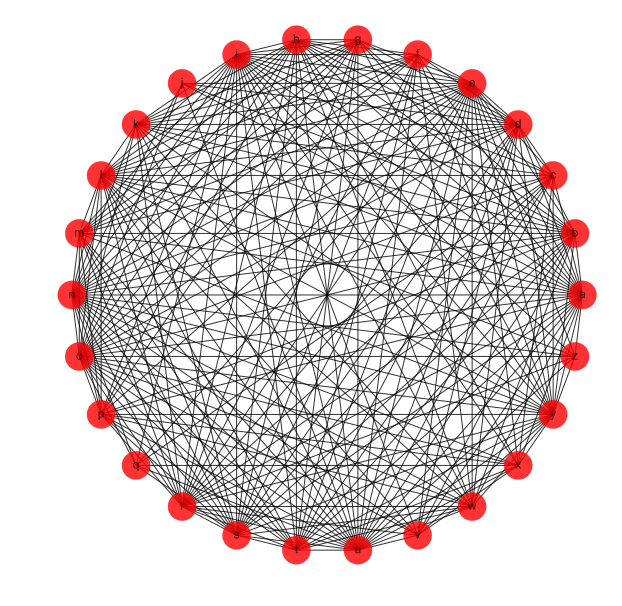

In [10]:
plt.figure(figsize=(8, 8))

nx.draw_shell(G, with_labels = True, node_size = 800, alpha = 0.8, arrows = True)

In [11]:
S = pd.Series({k: len(k) for k, v in bw.items()}).to_frame().rename(columns = {0: 'length'})

In [12]:
print('The number of sequence: %d'   % len(S))
print('The minimal length:     %.2f' % S['length'].min())
print('The maximum length:     %.2f' % S['length'].max())
print('The average length:     %.2f' % S['length'].mean())

The number of sequence: 9029
The minimal length:     2.00
The maximum length:     18.00
The average length:     7.15


In [13]:
# returns the vector of probabilities according to the transition matrix tm for s
def tm_prob_vector(tm, s):
    v = []
    for i in range(len(s) - 1):
        try:
            v.append(tm.loc[s[i]][s[i+1]])
        except KeyError:
            raise ValueError('Some elements of %s does not belong to the set E' % s)
    return(v)        

In [14]:
S['prob_gmean'] = S.apply(lambda x: scipy.stats.mstats.gmean(tm_prob_vector(tm2, x.name)), axis = 1)

In [15]:
S

,length,prob_gmean
transcribed,11,0.063146
from,4,0.092478
the,3,0.455104
john,4,0.008412
murray,6,0.054695
edition,7,0.115204
by,2,0.070465
david,5,0.061613
price,5,0.090946
email,5,0.054346


In [16]:
# Compute the distribution of values v(S) for all sequences from S. Compare it with (a distribution of) values of some other sequences - for example another book in some other language.

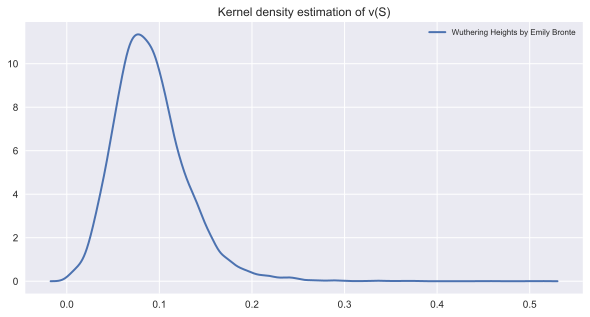

In [17]:
fig, axs = plt.subplots(figsize = (10, 5), ncols=1)

################################################################################
# draw kernel distribuion estimation of v(S)
################################################################################

# plt.sca(axs[1])

for i in range(1):
    kde = sm.nonparametric.KDEUnivariate(S['prob_gmean'])
    # kde.fit(kernel = 'epa', fft = False)
    
    #sklearn.neighbors.kde import KernelDensity
    
    kde.fit() # gaussian kernel with fft
    plt.plot(kde.support, kde.density, lw = 2, label = sequence_sets[i]['name'])

plt.title('Kernel density estimation of v(S)')
plt.legend(fontsize = 8)

plt.show()

# References
1. [The projects' descriptions on Vlado's site](http://vladowiki.fmf.uni-lj.si/doku.php?id=ru:hse:snet:stu)
2. [DataCamp: Markov Chains in Python: Beginner Tutorial](https://www.datacamp.com/community/tutorials/markov-chains-python-tutorial)